In [2]:
# Goal: Quick experiment overlaying the 777x triplett line onto itself offset to 6364 line
import sys, os, functools
import warnings
warnings.filterwarnings("ignore", module="dynesty.sampling")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import astropy.constants as aconst
import astropy.units as u
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import astropy.table as table
from astropy.cosmology import Planck15 as cosmology
import seaborn
import numba
import pandas as pd

try:
    import snelib19odp
except ImportError:
    sys.path.append('../lib')
import snelib19odp.dataloader as dataloader
import snelib19odp.const as const
import snelib19odp.analysis.oxygen as oxygen
import snelib19odp.blackbody as blackbody
import snelib19odp.specds as specds
import snelib19odp.analysis.spec_model as spec_model
import snelib19odp.gaussian as gaussian
import snelib19odp.utils as utils

egauss = np.vectorize(gaussian.elongated_gaussian)

In [3]:
sds = specds.load_dataset('SN2019odp')

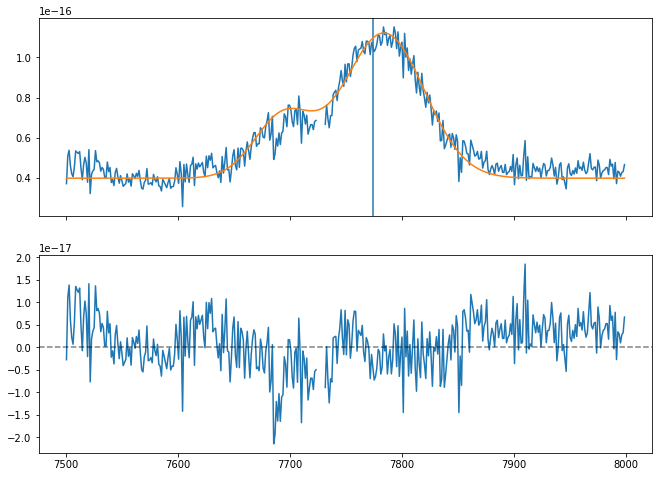

In [154]:
spec = sds['ZTF19abqwtfu_20200124_Keck1_v1']
wave = spec['restwave']
idx = np.logical_and(wave > 7500, wave < 8000)

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(11, 8))

ax1.plot(wave[idx], spec['flux'][idx])
ax1.axvline(7774)

flux = gaussian.gaussian(wave[idx]-10, 7774, 6.5e-15, 36) + gaussian.gaussian(wave[idx]-10, 7774-90, 2.0e-15, 26) + 0.4e-16
ax1.plot(wave[idx], flux)

ax2.plot(wave[idx], (spec['flux'][idx] - flux))
ax2.axhline(0, ls='--', alpha=0.5, color='black')

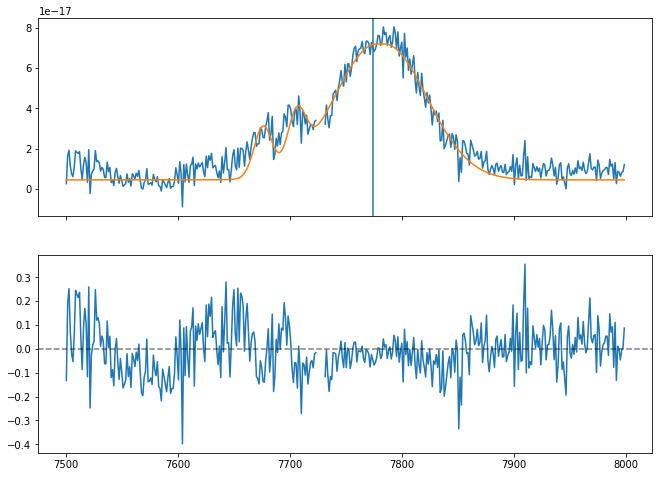

In [195]:
spec = sds['ZTF19abqwtfu_20200124_Keck1_v1']
wave = spec['restwave'] #- 7
idx = np.logical_and(wave > 7500, wave < 8000)

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(11, 8))

ax1.plot(wave[idx], spec['flux'][idx] - np.nanpercentile(spec['flux'][idx], 1))
ax1.axvline(7774)

flux = egauss(wave[idx]-7, 7774, 6.9e-15, 38, 7) \
    + gaussian.gaussian(wave[idx]-7, 7774-75, 0.5e-15, 8) \
    + gaussian.gaussian(wave[idx]-7, 7774-105, 0.5e-15, 8) \
    + 0.43e-16
#ax1.plot(wave[idx], flux)
ax1.plot(wave[idx], flux - np.percentile(flux, 50)+0.5e-17)

ax2.plot(wave[idx], (spec['flux'][idx] - flux)/flux)
ax2.axhline(0, ls='--', alpha=0.5, color='black')

In [60]:
plt.figure(figsize=(11,8))

# convert to velocity
C_KM_S = aconst.c.to(u.km/u.s).value

spec = sds['ZTF19abqwtfu_20200124_Keck1_v1']
wave = spec['restwave']
idx = np.logical_and(wave > 7550, wave < 8000)

wave = wave[idx]
flux = spec['flux'][idx]

center_wave = 7774
velocity = (wave - center_wave)/center_wave * C_KM_S

plt.plot(velocity, flux/np.nanpercentile(flux, 99))

spec = sds['ZTF19abqwtfu_20200124_Keck1_v1']
wave = spec['restwave']
idx = np.logical_and(wave > 6000, wave < 7000)

wave = wave[idx]
flux = spec['flux'][idx]

center_wave = 6300
velocity = (wave - center_wave)/center_wave * C_KM_S

plt.plot(velocity, flux/np.nanpercentile(flux, 99))

spec = sds['ZTF19abqwtfu_20200124_Keck1_v1']
wave = spec['restwave']
idx = np.logical_and(wave > 9000, wave < 9700)

wave = wave[idx]
flux = spec['flux'][idx]

center_wave = 9265
velocity = (wave - center_wave)/center_wave * C_KM_S

plt.plot(velocity, flux/np.nanpercentile(flux, 99), alpha=0.5)

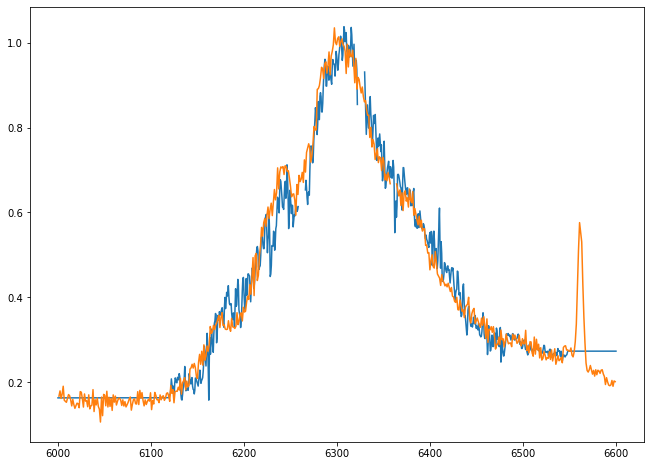

In [73]:
plt.figure(figsize=(11,8))

C_KM_S = aconst.c.to(u.km/u.s).value



spec = sds['ZTF19abqwtfu_20200124_Keck1_v1']
wave = spec['restwave']
idx = np.logical_and(wave > 7550, wave < 8000)

wave = wave[idx]
flux = spec['flux'][idx]
# remove continuum?
flux -= np.nanpercentile(flux, 1)

center_wave = 7774
velocity = (wave - center_wave)/center_wave * C_KM_S

wave_grid = np.linspace(6000, 6600, 1000)
center_wave = 6300
wave_6300 = velocity/C_KM_S * center_wave + center_wave
center_wave = 6364
wave_6364 = velocity/C_KM_S * center_wave + center_wave

flux_6300 = np.interp(wave_grid, wave_6300, flux)
flux_6364 = np.interp(wave_grid, wave_6364, flux)
flux = (flux_6300+flux_6364/3)*1 + egauss(wave_grid, 6300, 0.5e-14, 20, 230) + egauss(wave_grid, 6364, 0.5e-14/3, 20, 230) + 2e-17
plt.plot(wave_grid, flux/np.nanpercentile(flux, 99))
flux = flux_6300+flux_6364/3 
#plt.plot(wave_grid, flux/np.nanpercentile(flux, 99))

spec = sds['ZTF19abqwtfu_20200124_Keck1_v1']
wave = spec['restwave']
flux = spec['flux']
idx = np.logical_and(wave > 6000, wave < 6600)
plt.plot(wave[idx], flux[idx]/np.nanpercentile(flux[idx], 99))

#plt.plot(wave[idx], egauss(wave[idx], 6300, 10, 20, 300))
plt.savefig('2022-08-10-oxygen-expand-7774-to-doublett-keckearly.png')

In [54]:
# excellent match now!

# does speak towards it being optically thin!

In [55]:
# lets try with the not_late spectrum
plt.figure(figsize=(11,8))

C_KM_S = aconst.c.to(u.km/u.s).value

egauss = np.vectorize(gaussian.elongated_gaussian)

spec = sds['ZTF19abqwtfu_20200113_NOT_v1']
wave = spec['restwave']
idx = np.logical_and(wave > 7550, wave < 8000)

wave = wave[idx]
flux = spec['flux'][idx]

center_wave = 7774
velocity = (wave - center_wave)/center_wave * C_KM_S

wave_grid = np.linspace(6000, 6600, 1000)
center_wave = 6300
wave_6300 = velocity/C_KM_S * center_wave + center_wave
center_wave = 6364
wave_6364 = velocity/C_KM_S * center_wave + center_wave

flux_6300 = np.interp(wave_grid, wave_6300, flux)
flux_6364 = np.interp(wave_grid, wave_6364, flux)
flux = (flux_6300+flux_6364/3)*2# + egauss(wave_grid, 6300, 1e-14, 20, 230)
plt.plot(wave_grid, flux/np.nanpercentile(flux, 99))
flux = flux_6300+flux_6364/3 
#plt.plot(wave_grid, flux/np.nanpercentile(flux, 99))

spec = sds['ZTF19abqwtfu_20200113_NOT_v1']
wave = spec['restwave']
flux = spec['flux']
idx = np.logical_and(wave > 6000, wave < 6600)
plt.plot(wave[idx], flux[idx]/np.nanpercentile(flux[idx], 99))

plt.plot(wave[idx], egauss(wave[idx], 6300, 10, 20, 300))

In [74]:
# about the same, but worse

In [77]:
# now lets compare the 7774 line profile @ keck_early with keck_late
plt.figure(figsize=(11,8))

C_KM_S = aconst.c.to(u.km/u.s).value

egauss = np.vectorize(gaussian.elongated_gaussian)

spec = sds['ZTF19abqwtfu_20200124_Keck1_v1']
wave = spec['restwave']
idx = np.logical_and(wave > 7550, wave < 8000)

wave = wave[idx]
flux = spec['flux'][idx]
# remove continuum?
flux -= np.nanpercentile(flux, 1)

center_wave = 7774
velocity = (wave - center_wave)/center_wave * C_KM_S

wave_grid = np.linspace(6000, 6600, 1000)
center_wave = 6300
wave_6300 = velocity/C_KM_S * center_wave + center_wave
center_wave = 6364
wave_6364 = velocity/C_KM_S * center_wave + center_wave

flux_6300 = np.interp(wave_grid, wave_6300, flux)
flux_6364 = np.interp(wave_grid, wave_6364, flux)
flux = (flux_6300+flux_6364/3)*1 #+ egauss(wave_grid, 6300, 0.5e-14, 20, 230) + egauss(wave_grid, 6364, 0.5e-14/3, 20, 230) + 2e-17
plt.plot(wave_grid, flux/np.nanpercentile(flux, 99))
#flux = flux_6300+flux_6364/3 

spec = sds['ZTF19abqwtfu_20200821_Keck1_v1']
wave = spec['restwave']
flux = spec['flux']
idx = np.logical_and(wave > 6000, wave < 6500)
plt.plot(wave[idx], flux[idx]/np.nanpercentile(flux[idx], 99))

In [ ]:
# core is narrower and the 6364 feature is more pronounced (most likely due to the narrower core)
# thick shell feature addition is not needed

# but that extra feature at 6200 is still present

In [21]:
# try to construct it from gaussians:
spec = sds['ZTF19abqwtfu_20200124_Keck1_v1']
wave = spec['restwave']#-7
idx = np.logical_and(wave > 7500, wave < 8000)

C_KM_S = aconst.c.to(u.km/u.s).value

#flux = gaussian.gaussian(wave[idx], 7774, 6.0e-15, 36) + gaussian.gaussian(wave[idx], 7774-85, 2.5e-15, 26)# + 0.4e-16
flux = gaussian.gaussian(wave[idx]-10, 7774, 6.3e-15, 36) \
    + gaussian.gaussian(wave[idx]-10, 7774-75, 0.5e-15, 8) \
    + gaussian.gaussian(wave[idx]-10, 7774-105, 0.5e-15, 8) \
    + 0.4e-16

flux = egauss(wave[idx], 7774, 6.5e-15, 27, 20) \
    + egauss(wave[idx], 6300, 5e-15, 29, 200) \
    + 0.2e-16
flux -= np.nanpercentile(flux, 1)
flux += 0.45e-17
wave = wave[idx]

center_wave = 7774
velocity = (wave - center_wave)/center_wave * C_KM_S

wave_grid = np.linspace(6000, 6600, 1000)
center_wave = 6300
wave_6300 = velocity/C_KM_S * center_wave + center_wave
center_wave = 6364
wave_6364 = velocity/C_KM_S * center_wave + center_wave

flux_6300 = np.interp(wave_grid, wave_6300, flux)
flux_6364 = np.interp(wave_grid, wave_6364, flux)
flux = (flux_6300+flux_6364/2.5)*1 + egauss(wave_grid, 6300, 0.6e-14, 20, 250) + egauss(wave_grid, 6364, 0.6e-14/3, 20, 250) + 2e-17
plt.plot(wave_grid, flux/np.nanpercentile(flux, 99))

spec = sds['ZTF19abqwtfu_20200124_Keck1_v1']
wave = spec['restwave']
flux = spec['flux']
idx = np.logical_and(wave > 6000, wave < 6600)
plt.plot(wave[idx], flux[idx]/np.nanpercentile(flux[idx], 99))